In [27]:
from itertools import permutations, product

import functools

import tqdm

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



In [2]:
df = pd.read_csv('virus_genome/human_infecting_virus', delimiter='\t', header=None)
df[['ID', 'DNA Sequence']] = df[0].str.split(expand=True)
df = df.drop(0, axis=1)
df['isZoonotic'] = 1


df2 = pd.read_csv('virus_genome/Other_viruses', delimiter='\t', header=None)
df2[['ID', 'DNA Sequence']] = df2[0].str.split(expand=True)
df2 = df2.drop(0, axis=1)
df2['isZoonotic'] = 0

# make both have the same amount of samples..?

thresh = len(df)
# df2.drop(df2.index[thresh:len(df2.index)], inplace=True)

dfother = pd.DataFrame()
it = len(df)+1

print(len(df))
print(len(df2))
# iterate through each sequence
for i in range(len(df2)):
    dfother.at[it, 'DNA Sequence']=df2.at[i, 'DNA Sequence']
    dfother.at[it, 'isZoonotic']=int(0)
    dfother.at[it, 'ID']=df2.at[i, 'ID']
    it+=1


mergedDf = pd.concat([df, dfother], axis=0)


1236
8192


In [3]:
def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(row, permset, kmer):
    kmerdict=resetkmerdict(permset)
    st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf):
    kmer = 4
    print(mergedDf)
    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        l.append(assign_kmers_to_dict(row, permset, kmer))
        

    finalkmerdict=pd.DataFrame(l)
    mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    Y = mergedDf['isZoonotic']

    print(X)
    print(Y)
    return train_test_split(X, Y, test_size=0.2, random_state=1)

In [4]:
X_train, X_test, y_train, y_test = getTrainParams(mergedDf)

zz = X_train.head()


           ID                                       DNA Sequence  isZoonotic
0       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
1      129724  atactttacaattatcttgtaaaaagtagggtgtaaccgaaaaggg...         1.0
2       59303  atggcggacgtgtgacatcaccgttcgctctttctaggatcctttg...         1.0
3      120686  ttgttctacttcttactcattattataaattataatgtttgtataa...         1.0
4       99565  gtgaatgatgatggcgtcgaaagacgtcgttgcagctactgctgct...         1.0
...       ...                                                ...         ...
9424   268315  ggatccacagaactccttgtatgtacagccgcgggtacccacagca...         0.0
9425   130329  ctcatgtcattaataagaccatgcagaaaatgcaaatgaggcgaag...         0.0
9426  1239437  ccgaagtgggatggcggctgccgccgcttcggcgcttggcgcttcg...         0.0
9427   358812  gtatacgaggttagttcattctcgtatacacgattggacaaatcaa...         0.0
9428    11287  atggaaggaggaattcgtgcagcgttttcaggcctgaatgatgtta...         0.0

[9428 rows x 3 columns]


9428it [01:37, 96.80it/s] 


      acct  cgta  gtga  tgaa  tacg  aggc  agtg  attg  caca  cgct  ...  tagg  \
0       40    13    23    40    13    26    41    51    53     5  ...    21   
1       42    10    15    35    11    26    34    54    62    12  ...    27   
2       61    41    52    58    48    61    62    31    51    37  ...    22   
3       40     8    26    20    19    35    44    49    53     9  ...    27   
4       26     5    42    42     3    47    28    52    38    10  ...    27   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9423    10     4    11    20     1    16     8    14     8     2  ...    13   
9424   100    89   114   156    86    77   121   213   155    83  ...    85   
9425    24     6    35    54     7    29    40    45    51     9  ...    26   
9426    68    13    61    86    33    53    67    48    74    17  ...    53   
9427    69     6    44    35    14    57    47    43    88    17  ...    20   

      tgtt  cttt  ggat  ggct  tacc  aagg  attt  tat

In [21]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [22]:
# all 0s for some reason
print(X_test[:10])
predictions = lrmodel.predict(X_test)
print(accuracy_score(y_test, predictions))

      tcag  tttg  ccac  ctaa  acaa  ctca  taat  ctgg  gtat  caca  ...  accc  \
1302     4    28     5    11     7     3    22    13    12     3  ...     3   
6596    49    78    13    40    40    40   100    25    46    21  ...    14   
4095     9    23    11     8    11     8    16    13    10     7  ...     6   
7284   823  1586   355   379   902   470   813   524   630   465  ...   375   
4899    17    81    25    59    49    35    74    45    52    17  ...    37   
6289    74    73    32    38    94    51    32    43    30    50  ...    26   
7830   111    19   266     7   133   135     3   242    34   120  ...   273   
2048   215    58   250    34   124   165    12   357    71   102  ...   301   
7122   145   342   139   242   278   132   356   114   220   140  ...    64   
7488    12    11    10     5     5     5     4     7     5     4  ...    12   

      ccgg  caag  ctgc  ttga  atat  accg  agca  tttc  cagc  
1302     7     7    12    25    17     8     2    20     4  
6596    

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[-2.20939378e-05 -3.35067775e-05 -1.77573679e-04 -2.71168138e-04
 -1.04570585e-04 -6.74218830e-06 -8.23807926e-05 -1.95724415e-04
  6.30556602e-05 -8.11686544e-05  1.20973832e-04 -1.62273722e-04
 -1.23840323e-04 -2.23049633e-04 -2.34273102e-05 -1.85223431e-05
 -9.33616317e-05 -1.50787428e-04 -3.10976078e-05  6.48406957e-06
 -2.02802645e-04 -1.53804241e-04 -6.06829666e-06 -2.32788217e-05
 -4.29706712e-05 -1.08885967e-04 -1.23230506e-05 -1.29623263e-04
 -3.23079757e-05 -6.59108056e-05 -2.29161018e-04 -6.89614333e-05
  1.25064818e-06  2.45316665e-05 -1.37129839e-04 -2.21716298e-05
 -1.42948716e-04  3.69887253e-05  5.30036893e-05 -2.87971082e-05
 -1.36098496e-05 -2.32609084e-06  1.32133427e-05 -6.90881362e-05
 -1.13430414e-05 -9.48623728e-06 -6.86282188e-05 -6.16273335e-05
 -1.23146683e-04 -1.02381773e-04 -2.98789051e-05 -1.93231885e-04
 -8.13688823e-05 -9.80540594e-05 -6.57521130e-05 -9.42001038e-05
 -2.59918191e-05 -1.86038836e-05 -6.59664215e-08  8.27083890e-05
 -6.07737425e-07 -6.95361

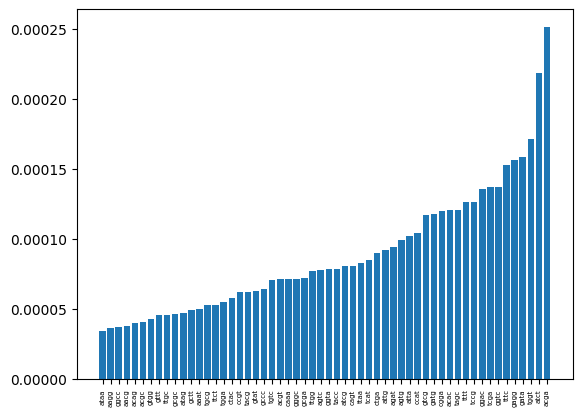

In [38]:
results = lrmodel.coef_[0]
print(results)

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[200:]], [x[1] for x in res[200:]])
plt.show()

In [7]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [8]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9109225874867445


In [9]:

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [10]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False, xgBoost=False):
    
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        predictions = model.predict(X_test)
        currAcc = accuracy_score(y_test, predictions)

        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")
            print(confusion_matrix(y_test, picklePredictions))

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            model=pickled_model
    return model

In [11]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

update!
[[1612   22]
 [ 251    1]]
curr 0.9459172852598091 pickle 0.8552492046659597
0.9459172852598091


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [12]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9459172852598091


In [13]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8
    # "warm_start":True
}



for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.957
no update
curr 0.957051961823966 pickle 0.9623541887592789
Learning rate:  0.075
Accuracy score (validation): 0.959
no update
curr 0.95864262990456 pickle 0.9623541887592789
Learning rate:  0.1
Accuracy score (validation): 0.957
no update
curr 0.957051961823966 pickle 0.9623541887592789
Learning rate:  0.15
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9623541887592789
Learning rate:  0.2
Accuracy score (validation): 0.956
no update
curr 0.9559915164369035 pickle 0.9623541887592789
Learning rate:  0.25
Accuracy score (validation): 0.959
no update
curr 0.9591728525980912 pickle 0.9623541887592789
Learning rate:  0.3
Accuracy score (validation): 0.957
no update
curr 0.9565217391304348 pickle 0.9623541887592789
Learning rate:  0.35
Accuracy score (validation): 0.955
no update
curr 0.954931071049841 pickle 0.9623541887592789
Learning rate:  0.4
Accuracy score (validation): 0.953
no update
curr 0.9528101

In [14]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8,
    "warm_start":True
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9655355249204666
Learning rate:  0.075
Accuracy score (validation): 0.962
no update
curr 0.9618239660657476 pickle 0.9655355249204666
Learning rate:  0.1
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9655355249204666
Learning rate:  0.15
Accuracy score (validation): 0.959
no update
curr 0.9591728525980912 pickle 0.9655355249204666
Learning rate:  0.2
Accuracy score (validation): 0.966
no update
curr 0.9655355249204666 pickle 0.9655355249204666
Learning rate:  0.25
Accuracy score (validation): 0.963
no update
curr 0.9628844114528102 pickle 0.9655355249204666
Learning rate:  0.3
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9655355249204666
Learning rate:  0.35
Accuracy score (validation): 0.962
no update
curr 0.9618239660657476 pickle 0.9655355249204666
Learning rate:  0.4
Accuracy score (validation): 0.963
no update
curr 0.96

In [15]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)


# print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
# print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))

print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))

{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.4}
{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.35}
Best GB Accuracy:  0.9623541887592789
Balanced GB Accuracy:  0.8809426667443804
Best rF Accuracy:  0.8547189819724285
Balanced rF Accuracy:  0.49662431271978397


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


precision recall: 0.9150372384473479
[0.00045723 0.00013599 0.00065591 ... 0.00053945 0.00509031 0.01590035]


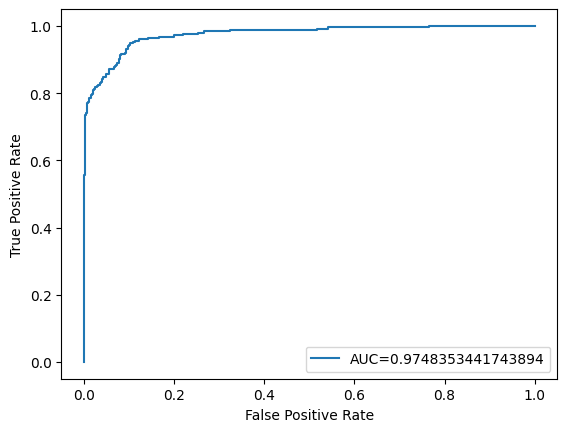

In [16]:
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


[0.3 0.1 0.1 ... 0.1 0.3 0.2]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


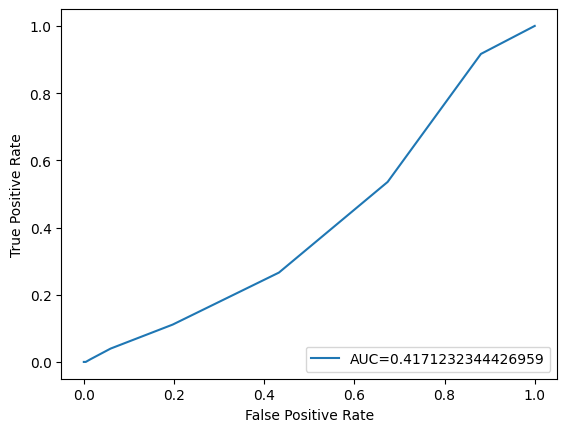

In [17]:
y_pred_proba = best_rF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [18]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.946 (0.014)


In [19]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.907 (0.019)
